# Predikcija kategorije proizvoda na osnovu naslova

## Poslovni problem

Online trgovinska platforma svakodnevno unosi veliki broj novih proizvoda.
Ručna klasifikacija proizvoda u odgovarajuće kategorije je spora i podložna greškama.

Cilj ovog projekta je razvoj modela mašinskog učenja koji automatski predviđa kategoriju proizvoda na osnovu njegovog naziva.

Na ovaj način proces unosa proizvoda postaje brži, precizniji i efikasniji.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import joblib

## Učitavanje i pregled podataka

Učitavamo dataset i uklanjamo eventualne razmake iz naziva kolona.

In [39]:
df = pd.read_csv("products.csv")

df.columns = df.columns.str.strip()

print("Nazivi kolona:")
print(df.columns)

Nazivi kolona:
Index(['product ID', 'Product Title', 'Merchant ID', 'Category Label',
       '_Product Code', 'Number_of_Views', 'Merchant Rating', 'Listing Date'],
      dtype='object')


In [40]:
df.head()

,product ID,Product Title,Merchant ID,Category Label,_Product Code,Number_of_Views,Merchant Rating,Listing Date
0,1,apple iphone 8 plus 64gb silver,1,Mobile Phones,QA-2276-XC,860.0,2.5,5/10/2024
1,2,apple iphone 8 plus 64 gb spacegrau,2,Mobile Phones,KA-2501-QO,3772.0,4.8,12/31/2024
2,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,Mobile Phones,FP-8086-IE,3092.0,3.9,11/10/2024
3,4,apple iphone 8 plus 64gb space grey,4,Mobile Phones,YI-0086-US,466.0,3.4,5/2/2022
4,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,Mobile Phones,NZ-3586-WP,4426.0,1.6,4/12/2023


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35311 entries, 0 to 35310
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product ID       35311 non-null  int64  
 1   Product Title    35139 non-null  object 
 2   Merchant ID      35311 non-null  int64  
 3   Category Label   35267 non-null  object 
 4   _Product Code    35216 non-null  object 
 5   Number_of_Views  35297 non-null  float64
 6   Merchant Rating  35141 non-null  float64
 7   Listing Date     35252 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 2.2+ MB


## Analiza distribucije kategorija

Provjeravamo koliko proizvoda ima u svakoj kategoriji.

In [42]:
df["Category Label"].value_counts().head(10)

,count
Category Label,
Fridge Freezers,5495
Washing Machines,4036
Mobile Phones,4020
CPUs,3771
TVs,3564
Fridges,3457
Dishwashers,3418
Digital Cameras,2696
Microwaves,2338


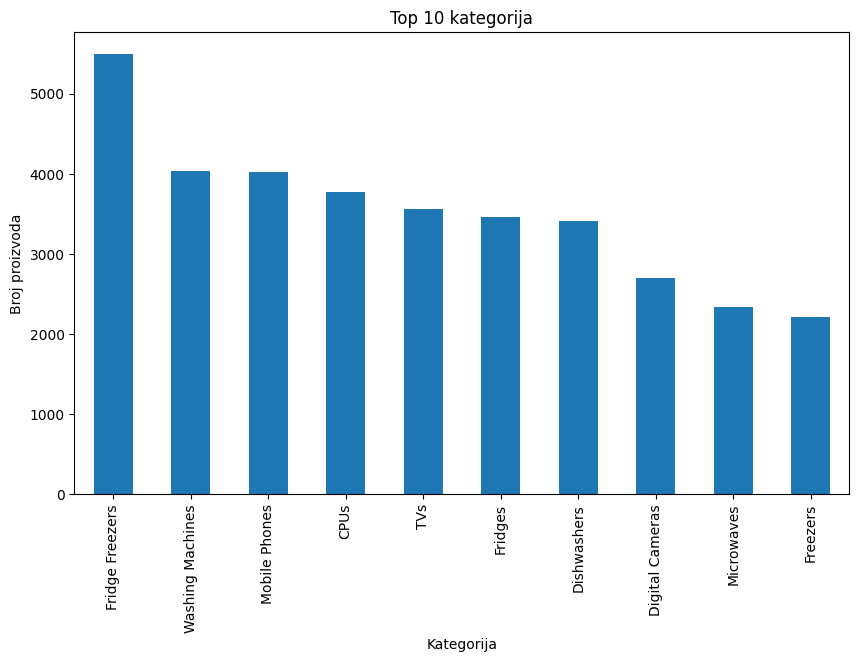

In [43]:
plt.figure(figsize=(10,6))
df["Category Label"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 kategorija")
plt.xlabel("Kategorija")
plt.ylabel("Broj proizvoda")
plt.show()

## Čišćenje podataka

Uklanjamo redove sa nedostajućim vrijednostima i standardizujemo tekst.

In [44]:
df = df.dropna(subset=["Product Title", "Category Label"])
df["Product Title"] = df["Product Title"].str.lower()

## Inženjering karakteristika

Dodajemo:
- dužinu naslova
- broj riječi u naslovu

In [45]:
df["duzina_naslova"] = df["Product Title"].apply(len)
df["broj_rijeci"] = df["Product Title"].apply(lambda x: len(x.split()))

## Definisanje ulaznih (X) i izlaznih (y) varijabli

In [46]:
X = df["Product Title"]
y = df["Category Label"]

## Podjela podataka na trening i test skup

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

## Model 1: TF-IDF + Logistic Regression

Koristimo TF-IDF za pretvaranje teksta u numeričke karakteristike i Logistic Regression za klasifikaciju.

In [48]:
log_model = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=10000)),
    ("clf", LogisticRegression(max_iter=1000))
])

log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)

print("Tačnost modela:", accuracy_score(y_test, y_pred_log))
print("\nKlasifikacioni izvještaj:\n")
print(classification_report(y_test, y_pred_log))

Tačnost modela: 0.9515669515669516

Klasifikacioni izvještaj:

                  precision    recall  f1-score   support

             CPU       0.00      0.00      0.00        17
            CPUs       0.98      1.00      0.99       749
 Digital Cameras       0.99      0.99      0.99       538
     Dishwashers       0.98      0.92      0.95       681
        Freezers       1.00      0.93      0.96       440
 Fridge Freezers       0.90      0.95      0.92      1094
         Fridges       0.86      0.91      0.88       687
      Microwaves       0.99      0.96      0.97       466
    Mobile Phone       0.00      0.00      0.00        11
   Mobile Phones       0.95      0.99      0.97       801
             TVs       0.98      0.98      0.98       708
Washing Machines       0.96      0.95      0.95       803
          fridge       0.00      0.00      0.00        25

        accuracy                           0.95      7020
       macro avg       0.74      0.74      0.74      7020
    wei

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Model 2: TF-IDF + Naive Bayes

Testiramo alternativni model radi poređenja performansi.

In [49]:
nb_model = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=10000)),
    ("clf", MultinomialNB())
])

nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)

print("Tačnost Naive Bayes modela:", accuracy_score(y_test, y_pred_nb))

Tačnost Naive Bayes modela: 0.9307692307692308


## Matrica zabune

Vizualizujemo gdje model najčešće pravi greške.

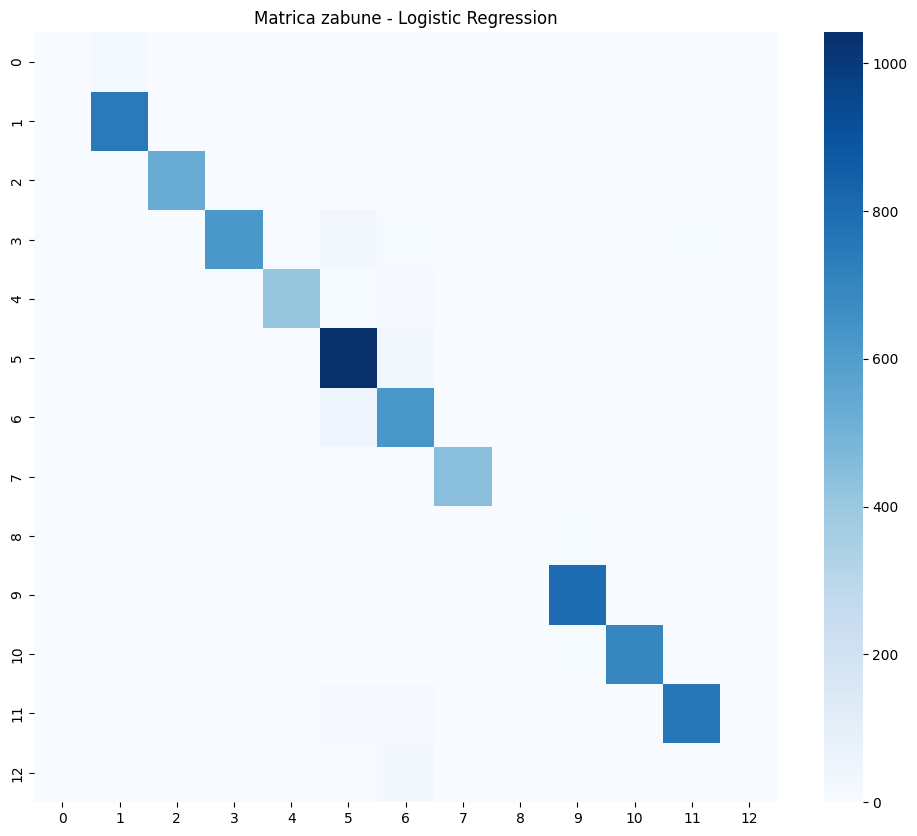

In [50]:
cm = confusion_matrix(y_test, y_pred_log)

plt.figure(figsize=(12,10))
sns.heatmap(cm, cmap="Blues")
plt.title("Matrica zabune - Logistic Regression")
plt.show()

## Zaključak

U ovom projektu razvijen je model za klasifikaciju proizvoda na osnovu naziva proizvoda koristeći TF-IDF vektorizaciju i dva algoritma mašinskog učenja: Logistic Regression i Naive Bayes.

Logistic Regression model postigao je tačnost od približno 95%, dok je Naive Bayes model postigao tačnost od približno 93%.

Rezultati pokazuju da Logistic Regression daje bolje performanse i stabilnije rezultate, posebno kod većih kategorija proizvoda.

Primijećeno je da modeli imaju slabije rezultate kod kategorija sa malim brojem uzoraka, što je posljedica nebalansiranog skupa podataka.

Na osnovu dobijenih rezultata, Logistic Regression model je izabran kao finalni model za dalju upotrebu.

In [51]:
import joblib

joblib.dump(log_model, "product_classifier.pkl")

print("Model je uspješno sačuvan.")

Model je uspješno sačuvan.
